# Word embedding using GloVe
[GloVe embeddings are global embeddings](https://www.aclweb.org/anthology/D14-1162.pdf_). A GloVe model tries to predict, given two elements out of the corpus vocabulary, their cooccurrence frequency.

GloVe model do not scale nicely with the vocabulary size, as the cooccurrence matrix requires to be fully rendered (clearly as a CSR) before the model is trained, hence occupying a significant memory portion on huge texts.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## The parameters for this example
We are going to use as batch size $512$, the number of texts to use for each training epoch. The result embedding size, the space of the resulting vectors, is $100$. The window size is $3$, meaning the context will be formed of the four words after and before the one we are considering as the center. 

The negative samples are the number of samples to randomly extract as negatives during the NCE. We are going to use $10$ for these values. 

Relative to the early stopping mechanism, we are going to monitor the training loss, using a variation delta $0.0001$ and a patience of $50$ epochs.

In [28]:
batch_size = 2**14
embedding_size = 30
window_size=10
delta=0.00001
patience=20
min_counts=5

## Using NLTK
Since we are going to use NLTK, other than installing the package, don't forget to also [execute the download of the data related to the package](https://www.nltk.org/data.html), such as the stopwords:

```bash
python -m nltk.downloader all
```

NLTK is a library with *many* tools for executing NLP, that here we are not exploring in the necessary depth.

Before starting to write your custom tokenizer, please to look into NLTK and choose the tools and are useful for your use case.

## Loading the texts
Here we are going to take in consideration the Hillary emails:

In [3]:
import pandas as pd
import numpy as np
emails = pd.read_csv("../data/texts/Emails.csv")["RawText"].tolist()

## Encoding the texts

Here we use the [the Keras Tokenizer](https://keras.io/api/preprocessing/text/). This tokenizer **is NOT by any means complete** and should only be used for examples and educational porposes.

In this **very simple** tokenizer, we apply stemming using Porter stemming and drop english stop words.

For any real world application, you will also need a custom synonims' dictionary: here we are using a general porpose synonims dictionary that may apply or not in your own application.

In [4]:
from embiggen import CorpusTransformer

transformer = CorpusTransformer()
transformer.fit(emails, min_count=min_counts)
encoded_emails = transformer.transform(emails, min_length=window_size*2+1)

In [5]:
print(f"The transformer will use {transformer.vocabulary_size} different terms.")

The transformer will use 16064 different terms.


## Creating the training data
We create the training data as the CSR representation of the cooccurrence matrix:

In [7]:
from ensmallen_graph import preprocessing

words, ctxs, freq = preprocessing.cooccurence_matrix(
    encoded_emails,
    window_size=window_size,
    verbose=False
)

## Creating the embedding model
Here, finally, we create the embedding model. If available, we setup the model so to run on multiple GPUs:

In [29]:
from tensorflow.distribute import MirroredStrategy
from embiggen import GloVe
from tensorflow.keras.optimizers import Nadam

strategy = MirroredStrategy()
with strategy.scope():
    model = GloVe(
        vocabulary_size=transformer.vocabulary_size,
        embedding_size=embedding_size,
    )

model.summary()

Model: "GloVe"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 30)        481920      words_embedding[0][0]            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 30)        481920      input_5[0][0]                    
______________________________________________________________________________________________

### Training the embedding model
Now here we execute the training of the embedding model:

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(
    (words, ctxs), freq,
    epochs=1000,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(
            "loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(monitor="loss", patience=patience//2)
    ]
)

Epoch 1/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0353 - lr: 0.0010
Epoch 2/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0178 - lr: 0.0010
Epoch 3/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0069 - lr: 0.0010
Epoch 4/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0042 - lr: 0.0010
Epoch 5/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0031 - lr: 0.0010
Epoch 6/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0024 - lr: 0.0010
Epoch 7/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0020 - lr: 0.0010
Epoch 8/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0018 - lr: 0.0010
Epoch 9/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0016 - lr: 0.0010
Epoch 10/1000
387/387 [==============================] - 3s 7ms/step - loss: 0.0014 - lr: 0.0010
Epoch 11/1000
387/387 [================

### Plotting the history
We plot the training history:

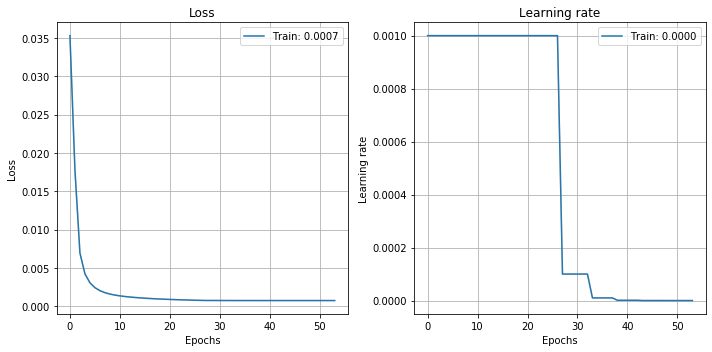

In [31]:
from plot_keras_history import plot_history
plot_history(history)

## Computing the cosine similarities

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(model.embedding)

In [36]:
word = "one"
similarity = similarities[transformer.get_word_id(transformer.get_synonim(word))]
transformer.reverse_transform([
    similarity.argsort()[-10:]
])

['abedin best office go security — original raise millscd one']

In [37]:
similarity[similarity.argsort()[-10:]]

array([0.9443527 , 0.94543827, 0.94576085, 0.94579947, 0.9460854 ,
       0.9464254 , 0.94704115, 0.9503475 , 0.951759  , 1.        ],
      dtype=float32)